<a href="https://colab.research.google.com/github/vivek6311/Artificial-Intelligence-with-Python/blob/master/Lab3_Lecture_TLP23.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# In-Depth: Support Vector Machines

Support vector machines (SVMs) are a particularly powerful and flexible class of supervised algorithms for both classification and regression.
In this section, we will develop the intuition behind support vector machines and their use in classification problems.

We begin with the standard imports:

In [ ]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats

# use seaborn plotting defaults
import seaborn as sns; sns.set()

## Motivating Support Vector Machines

*Generative classification* (learned a simple model describing the distribution of each underlying class, and used these generative models to probabilistically determine labels for new points.) is used in Bayesian classification; here we will consider instead *discriminative classification*: rather than modeling each class, we simply find a line or curve (in two dimensions) or manifold (in multiple dimensions) that divides the classes from each other.

As an example of this, consider the simple case of a classification task, in which the two classes of points are well separated:

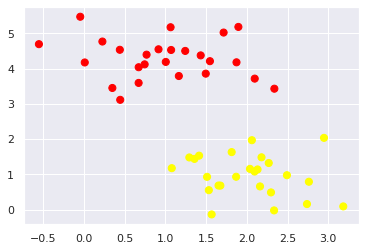

In [ ]:
from sklearn.datasets import make_blobs
X, y = make_blobs(n_samples=50, centers=2,
                  random_state=0, cluster_std=0.60)
plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='autumn');

A linear discriminative classifier would attempt to draw a straight line separating the two sets of data, and thereby create a model for classification.
For two dimensional data like that shown here, this is a task we could do by hand.
But immediately we see a problem: there is more than one possible dividing line that can perfectly discriminate between the two classes!

We can draw them as follows:

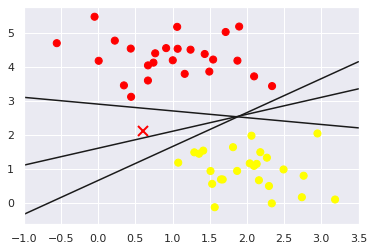

In [ ]:
xfit = np.linspace(-1, 3.5)
plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='autumn')
plt.plot([0.6], [2.1], 'x', color='red', markeredgewidth=2, markersize=10)

for m, b in [(1, 0.65), (0.5, 1.6), (-0.2, 2.9)]:
    plt.plot(xfit, m * xfit + b, '-k')

plt.xlim(-1, 3.5);

These are three *very* different separators which, nevertheless, perfectly discriminate between these samples.
Depending on which you choose, a new data point (e.g., the one marked by the "X" in this plot) will be assigned a different label!
Evidently our simple intuition of "drawing a line between classes" is not enough, and we need to think a bit deeper.

## Support Vector Machines: Maximizing the *Margin*

Support vector machines offer one way to improve on this.
The intuition is this: rather than simply drawing a zero-width line between the classes, we can draw around each line a *margin* of some width, up to the nearest point.
Here is an example of how this might look:

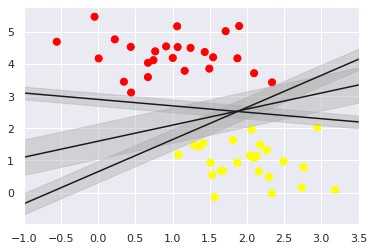

In [ ]:
xfit = np.linspace(-1, 3.5)
plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='autumn')

for m, b, d in [(1, 0.65, 0.33), (0.5, 1.6, 0.55), (-0.2, 2.9, 0.2)]:
    yfit = m * xfit + b
    plt.plot(xfit, yfit, '-k')
    plt.fill_between(xfit, yfit - d, yfit + d, edgecolor='none',
                     color='#AAAAAA', alpha=0.4)

plt.xlim(-1, 3.5);
#sklearn.svm import SVR

In support vector machines, the line that maximizes this margin is the one we will choose as the optimal model.
Support vector machines are an example of such a *maximum margin* estimator.

### Fitting a support vector machine

Let's see the result of an actual fit to this data: we will use Scikit-Learn's support vector classifier to train an SVM model on this data.
For the time being, we will use a linear kernel and set the ``C`` parameter to a very large number (we'll discuss the meaning of these in more depth momentarily).

In [ ]:
from sklearn.svm import SVC # "Support vector classifier"
model = SVC(kernel='linear', C=1E10)
model.fit(X, y)

SVC(C=10000000000.0, kernel='linear')

To better visualize what's happening here, let's create a quick convenience function that will plot SVM decision boundaries for us:

In [ ]:
def plot_svc_decision_function(model, ax=None, plot_support=True):
    """Plot the decision function for a 2D SVC"""
    if ax is None:
        ax = plt.gca()
    xlim = ax.get_xlim()
    ylim = ax.get_ylim()
    
    # create grid to evaluate model
    x = np.linspace(xlim[0], xlim[1], 30)
    y = np.linspace(ylim[0], ylim[1], 30)
    Y, X = np.meshgrid(y, x)
    xy = np.vstack([X.ravel(), Y.ravel()]).T
    P = model.decision_function(xy).reshape(X.shape)
    
    # plot decision boundary and margins
    ax.contour(X, Y, P, colors='k',
               levels=[-1, 0, 1], alpha=0.5,
               linestyles=['--', '-', '--'])
    
    # plot support vectors
    if plot_support:
        ax.scatter(model.support_vectors_[:, 0],
                   model.support_vectors_[:, 1],
                   s=300, linewidth=1, facecolors='none');
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)

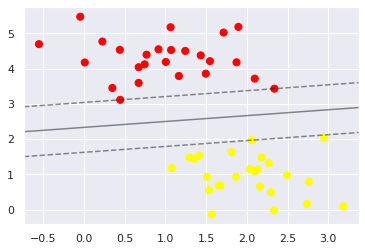

In [ ]:
plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='autumn')
plot_svc_decision_function(model);

This is the dividing line that maximizes the margin between the two sets of points.
Notice that a few of the training points just touch the margin: they are indicated by the black circles in this figure.
These points are the pivotal elements of this fit, and are known as the *support vectors*, and give the algorithm its name.
In Scikit-Learn, the identity of these points are stored in the ``support_vectors_`` attribute of the classifier:

In [ ]:
model.support_vectors_

array([[0.44359863, 3.11530945],
       [2.33812285, 3.43116792],
       [2.06156753, 1.96918596]])

A key to this classifier's success is that for the fit, only the position of the support vectors matter; any points further from the margin which are on the correct side do not modify the fit!
Technically, this is because these points do not contribute to the loss function used to fit the model, so their position and number do not matter so long as they do not cross the margin.

We can see this, for example, if we plot the model learned from the first 60 points and first 120 points of this dataset:

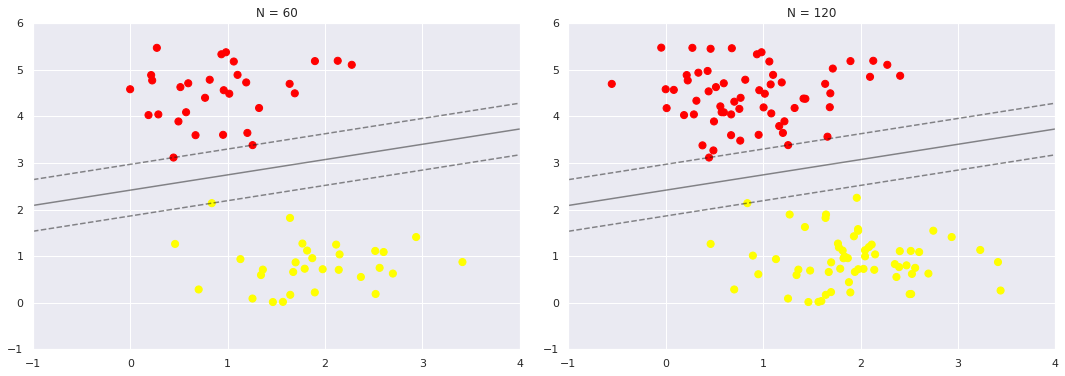

In [ ]:
def plot_svm(N=10, ax=None):
    X, y = make_blobs(n_samples=200, centers=2,
                      random_state=0, cluster_std=0.60)
    X = X[:N]
    y = y[:N]
    model = SVC(kernel='linear', C=1E10)
    model.fit(X, y)
    
    ax = ax or plt.gca()
    ax.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='autumn')
    ax.set_xlim(-1, 4)
    ax.set_ylim(-1, 6)
    plot_svc_decision_function(model, ax)

fig, ax = plt.subplots(1, 2, figsize=(16, 6))
fig.subplots_adjust(left=0.0625, right=0.95, wspace=0.1)
for axi, N in zip(ax, [60, 120]):
    plot_svm(N, axi)
    axi.set_title('N = {0}'.format(N))

In the left panel, we see the model and the support vectors for 60 training points.
In the right panel, we have doubled the number of training points, but the model has not changed: the three support vectors from the left panel are still the support vectors from the right panel.
This insensitivity to the exact behavior of distant points is one of the strengths of the SVM model.

If you are running this notebook live, you can use IPython's interactive widgets to view this feature of the SVM model interactively:

In [ ]:
from ipywidgets import interact, fixed
interact(plot_svm, N=[10,20, 50,100, 150, 200, 500, 1000], ax=fixed(None));

interactive(children=(Dropdown(description='N', options=(10, 20, 50, 100, 150, 200, 500, 1000), value=10), Out…

### Beyond linear boundaries: Kernel SVM

Where SVM becomes extremely powerful is when it is combined with *kernels*.
We have seen a version of kernels before, in the basis function regressions of Linear Regression
There we projected our data into higher-dimensional space defined by polynomials and Gaussian basis functions, and thereby were able to fit for nonlinear relationships with a linear classifier.

In SVM models, we can use a version of the same idea.
To motivate the need for kernels, let's look at some data that is not linearly separable:

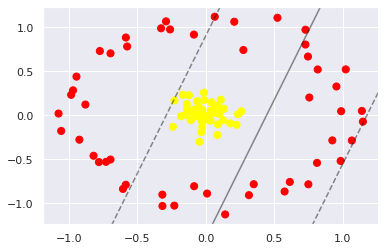

In [ ]:
# old package
from sklearn.datasets import make_circles
X, y = make_circles(100, factor=.1, noise=.1)

clf = SVC(kernel='linear').fit(X, y)

plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='autumn')
plot_svc_decision_function(clf, plot_support=False);

It is clear that no linear discrimination will *ever* be able to separate this data.
Think about how we might project the data into a higher dimension such that a linear separator *would* be sufficient.
For example, one simple projection we could use would be to compute a *radial basis function* centered on the middle clump:

In [ ]:
r = np.exp(-(X ** 2).sum(1))

We can visualize this extra data dimension using a three-dimensional plot—if you are running this notebook live, you will be able to use the sliders to rotate the plot:

In [ ]:
from mpl_toolkits import mplot3d

def plot_3D(elev=30, azim=30, X=X, y=y):
    ax = plt.subplot(projection='3d')
    ax.scatter3D(X[:, 0], X[:, 1], r, c=y, s=50, cmap='autumn')
    ax.view_init(elev=elev, azim=azim)
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.set_zlabel('r')

interact(plot_3D, elev=[-90, 90], azip=(-180, 180),
         X=fixed(X), y=fixed(y));

interactive(children=(Dropdown(description='elev', options=(-90, 90), value=-90), IntSlider(value=30, descript…

We can see that with this additional dimension, the data becomes trivially linearly separable, by drawing a separating plane at, say, *r*=0.7.

Here we had to choose and carefully tune our projection: if we had not centered our radial basis function in the right location, we would not have seen such clean, linearly separable results.
In general, the need to make such a choice is a problem: we would like to somehow automatically find the best basis functions to use.

One strategy to this end is to compute a basis function centered at *every* point in the dataset, and let the SVM algorithm sift through the results.
This type of basis function transformation is known as a *kernel transformation*, as it is based on a similarity relationship (or kernel) between each pair of points.

A potential problem with this strategy—projecting $N$ points into $N$ dimensions—is that it might become very computationally intensive as $N$ grows large.
However, because of a neat little procedure known as the [*kernel trick*](https://en.wikipedia.org/wiki/Kernel_trick), a fit on kernel-transformed data can be done implicitly—that is, without ever building the full $N$-dimensional representation of the kernel projection!
This kernel trick is built into the SVM, and is one of the reasons the method is so powerful.

In Scikit-Learn, we can apply kernelized SVM simply by changing our linear kernel to an RBF (radial basis function) kernel, using the ``kernel`` model hyperparameter:

In [ ]:
clf = SVC(kernel='rbf', C=1E6)
clf.fit(X, y)

SVC(C=1000000.0)

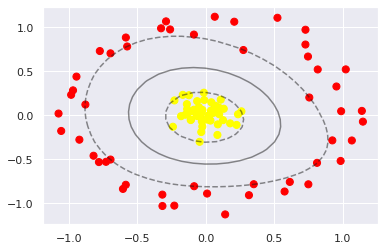

In [ ]:
plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='autumn')
plot_svc_decision_function(clf)
plt.scatter(clf.support_vectors_[:, 0], clf.support_vectors_[:, 1],
            s=300, lw=1, facecolors='none');

Using this kernelized support vector machine, we learn a suitable nonlinear decision boundary.
This kernel transformation strategy is used often in machine learning to turn fast linear methods into fast nonlinear methods, especially for models in which the kernel trick can be used.

### Tuning the SVM: Softening Margins

Our discussion thus far has centered around very clean datasets, in which a perfect decision boundary exists.
But what if your data has some amount of overlap?
For example, you may have data like this:

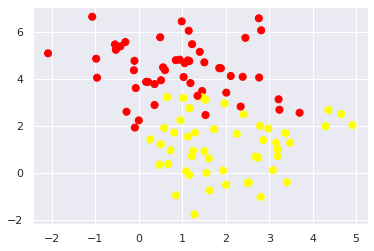

In [ ]:
X, y = make_blobs(n_samples=100, centers=2,
                  random_state=0, cluster_std=1.2)
plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='autumn');

To handle this case, the SVM implementation has a bit of a fudge-factor which "softens" the margin: that is, it allows some of the points to creep into the margin if that allows a better fit.
The hardness of the margin is controlled by a tuning parameter, most often known as $C$.
For very large $C$, the margin is hard, and points cannot lie in it.
For smaller $C$, the margin is softer, and can grow to encompass some points.

The plot shown below gives a visual picture of how a changing $C$ parameter affects the final fit, via the softening of the margin:

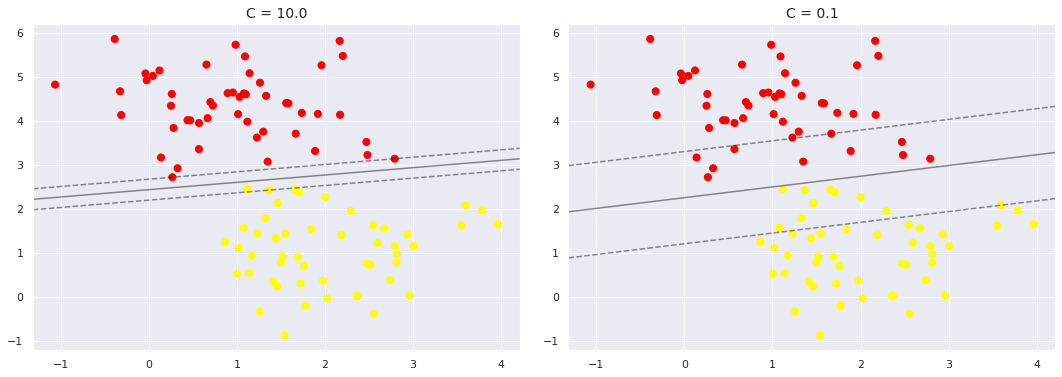

In [ ]:
X, y = make_blobs(n_samples=100, centers=2,
                  random_state=0, cluster_std=0.8)

fig, ax = plt.subplots(1, 2, figsize=(16, 6))
fig.subplots_adjust(left=0.0625, right=0.95, wspace=0.1)

for axi, C in zip(ax, [10.0, 0.1]):
    model = SVC(kernel='linear', C=C).fit(X, y)
    axi.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='autumn')
    plot_svc_decision_function(model, axi)
    axi.scatter(model.support_vectors_[:, 0],
                model.support_vectors_[:, 1],
                s=300, lw=1, facecolors='none');
    axi.set_title('C = {0:.1f}'.format(C), size=14)

The optimal value of the $C$ parameter will depend on your dataset, and should be tuned using cross-validation or a similar procedure 

## Example: Face Recognition

As an example of support vector machines in action, let's take a look at the facial recognition problem.
We will use the Labeled Faces in the Wild dataset, which consists of several thousand collated photos of various public figures.
A fetcher for the dataset is built into Scikit-Learn:

In [ ]:
from sklearn.datasets import fetch_lfw_people
faces = fetch_lfw_people(min_faces_per_person=60)
print(faces.target_names)
print(faces.images.shape)

['Ariel Sharon' 'Colin Powell' 'Donald Rumsfeld' 'George W Bush'
 'Gerhard Schroeder' 'Hugo Chavez' 'Junichiro Koizumi' 'Tony Blair']
(1348, 62, 47)


Let's plot a few of these faces to see what we're working with:

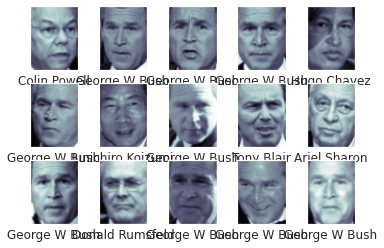

In [ ]:
fig, ax = plt.subplots(3, 5)
for i, axi in enumerate(ax.flat):
    axi.imshow(faces.images[i], cmap='bone')
    axi.set(xticks=[], yticks=[],
            xlabel=faces.target_names[faces.target[i]])

Each image contains [62×47] or nearly 3,000 pixels.
We could proceed by simply using each pixel value as a feature, but often it is more effective to use some sort of preprocessor to extract more meaningful features; here we will use a principal component analysis to extract 150 fundamental components to feed into our support vector machine classifier.
We can do this most straightforwardly by packaging the preprocessor and the classifier into a single pipeline:

In [ ]:
from sklearn.svm import SVC
from sklearn.decomposition import PCA as RandomizedPCA
from sklearn.pipeline import make_pipeline

pca = RandomizedPCA(n_components=150, whiten=True, random_state=42)
svc = SVC(kernel='rbf', class_weight='balanced')
model = make_pipeline(pca, svc)

For the sake of testing our classifier output, we will split the data into a training and testing set:

In [ ]:
from sklearn.model_selection import train_test_split
Xtrain, Xtest, ytrain, ytest = train_test_split(faces.data, faces.target,
                                                random_state=42)

Finally, we can use a grid search cross-validation to explore combinations of parameters.
Here we will adjust ``C`` (which controls the margin hardness) and ``gamma`` (which controls the size of the radial basis function kernel), and determine the best model:

In [ ]:
from sklearn.model_selection import GridSearchCV
param_grid = {'svc__C': [1, 5, 10, 50],
              'svc__gamma': [0.0001, 0.0005, 0.001]}
grid = GridSearchCV(model, param_grid)

%time grid.fit(Xtrain, ytrain)
print(grid.best_params_)

CPU times: user 41.4 s, sys: 30.5 s, total: 1min 11s
Wall time: 45.5 s
{'svc__C': 10, 'svc__gamma': 0.001}


The optimal values fall toward the middle of our grid; if they fell at the edges, we would want to expand the grid to make sure we have found the true optimum.

Now with this cross-validated model, we can predict the labels for the test data, which the model has not yet seen:

In [ ]:
model = grid.best_estimator_
yfit = model.predict(Xtest)

Let's take a look at a few of the test images along with their predicted values:

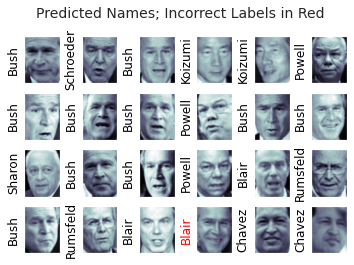

In [ ]:
fig, ax = plt.subplots(4, 6)
for i, axi in enumerate(ax.flat):
    axi.imshow(Xtest[i].reshape(62, 47), cmap='bone')
    axi.set(xticks=[], yticks=[])
    axi.set_ylabel(faces.target_names[yfit[i]].split()[-1],
                   color='black' if yfit[i] == ytest[i] else 'red')
fig.suptitle('Predicted Names; Incorrect Labels in Red', size=14);

Out of this small sample, our optimal estimator mislabeled only a single face (Bush’s
face in the bottom row was mislabeled as Blair).
We can get a better sense of our estimator's performance using the classification report, which lists recovery statistics label by label:

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(ytest, yfit,
                            target_names=faces.target_names))

                   precision    recall  f1-score   support

     Ariel Sharon       0.65      0.73      0.69        15
     Colin Powell       0.80      0.87      0.83        68
  Donald Rumsfeld       0.74      0.84      0.79        31
    George W Bush       0.92      0.83      0.88       126
Gerhard Schroeder       0.86      0.83      0.84        23
      Hugo Chavez       0.93      0.70      0.80        20
Junichiro Koizumi       0.92      1.00      0.96        12
       Tony Blair       0.85      0.95      0.90        42

         accuracy                           0.85       337
        macro avg       0.83      0.84      0.84       337
     weighted avg       0.86      0.85      0.85       337



We might also display the confusion matrix between these classes:

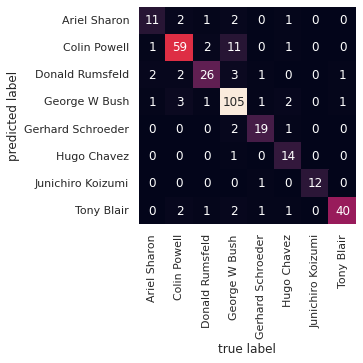

In [ ]:
from sklearn.metrics import confusion_matrix
mat = confusion_matrix(ytest, yfit)
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False,
            xticklabels=faces.target_names,
            yticklabels=faces.target_names)
plt.xlabel('true label')
plt.ylabel('predicted label');

This helps us get a sense of which labels are likely to be confused by the estimator.

For a real-world facial recognition task, in which the photos do not come pre-cropped into nice grids, the only difference in the facial classification scheme is the feature selection: you would need to use a more sophisticated algorithm to find the faces, and extract features that are independent of the pixellation.
For this kind of application, one good option is to make use of OpenCV, which, among other things, includes pre-trained implementations of state-of-the-art feature extraction tools for images in general and faces in particular.

## Support Vector Machine Summary

We have seen here a brief intuitive introduction to the principals behind support vector machines.
These methods are a powerful classification method for a number of reasons:

- Their dependence on relatively few support vectors means that they are very compact models, and take up very little memory.
- Once the model is trained, the prediction phase is very fast.
- Because they are affected only by points near the margin, they work well with high-dimensional data—even data with more dimensions than samples, which is a challenging regime for other algorithms.
- Their integration with kernel methods makes them very versatile, able to adapt to many types of data.

However, SVMs have several disadvantages as well:

- The scaling with the number of samples $N$ is $\mathcal{O}[N^3]$ at worst, or $\mathcal{O}[N^2]$ for efficient implementations. For large numbers of training samples, this computational cost can be prohibitive.
- The results are strongly dependent on a suitable choice for the softening parameter $C$. This must be carefully chosen via cross-validation, which can be expensive as datasets grow in size.
- The results do not have a direct probabilistic interpretation. This can be estimated via an internal cross-validation (see the ``probability`` parameter of ``SVC``), but this extra estimation is costly.

With those traits in mind, I generally only turn to SVMs once other simpler, faster, and less tuning-intensive methods have been shown to be insufficient for my needs.
Nevertheless, if you have the CPU cycles to commit to training and cross-validating an SVM on your data, the method can lead to excellent results.

#### https://github.com/ageron/handson-ml2/blob/master/05_support_vector_machines.ipynb

# Boosting

Gradient boosting refers to a class of ensemble machine learning algorithms that can be used for classification or regression predictive modeling problems.


Ensembles are constructed from decision tree models. Trees are added one at a time to the ensemble and fit to correct the prediction errors made by prior models. This is a type of ensemble machine learning model is referred to as boosting

Naive gradient boosting is a greedy algorithm and can overfit the training dataset quickly.

It can benefit from regularization methods that penalize various parts of the algorithm and generally improve the performance of the algorithm by reducing overfitting.

Enhancement:



1.   Tree Constraints: such as the depth of the trees and the number of trees used in the ensemble.

2.   Weighted Updates: such as a learning rate used to limit how much each tree contributes to the ensemble.

3.   Random sampling: such as fitting trees on random subsets of features and samples.


## Gradient Boosting Scikit-Learn API

In [ ]:
# check scikit-learn version
import sklearn
print(sklearn.__version__)

1.0.2


## GB for classification

In [ ]:
# test classification dataset
from sklearn.datasets import make_classification
# define dataset
X, y = make_classification(n_samples=1000, n_features=20, n_informative=15, n_redundant=5, random_state=7)
# summarize the dataset
print(X.shape, y.shape)

(1000, 20) (1000,)


We will evaluate the model using repeated stratified k-fold cross-validation, with three repeats and 10 folds. We will report the mean and standard deviation of the accuracy of the model across all repeats and folds.



In [ ]:
# evaluate gradient boosting algorithm for classification
from numpy import mean
from numpy import std
from sklearn.datasets import make_classification
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.ensemble import GradientBoostingClassifier
# define dataset
X, y = make_classification(n_samples=1000, n_features=20, n_informative=15, n_redundant=5, random_state=7)
# define the model
model = GradientBoostingClassifier()
# define the evaluation method
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
# evaluate the model on the dataset
n_scores = cross_val_score(model, X, y, scoring='accuracy', cv=cv, n_jobs=-1)
# report performance
print('Mean Accuracy: %.3f (%.3f)' % (mean(n_scores), std(n_scores)))

Mean Accuracy: 0.898 (0.030)


In [ ]:
# The example below demonstrates this on our binary classification dataset.

# make predictions using gradient boosting for classification
from sklearn.datasets import make_classification
from sklearn.ensemble import GradientBoostingClassifier
# define dataset
X, y = make_classification(n_samples=1000, n_features=20, n_informative=15, n_redundant=5, random_state=7)
# define the model
model = GradientBoostingClassifier()
# fit the model on the whole dataset
model.fit(X, y)
# make a single prediction
row = [0.2929949, -4.21223056, -1.288332, -2.17849815, -0.64527665, 2.58097719, 0.28422388, -7.1827928, -1.91211104, 2.73729512, 0.81395695, 3.96973717, -2.66939799, 3.34692332, 4.19791821, 0.99990998, -0.30201875, -4.43170633, -2.82646737, 0.44916808]
yhat = model.predict([row])
# summarize prediction
print('Predicted Class: %d' % yhat[0])

Predicted Class: 1


## Gradient Boosting for Regression


In [ ]:
# test regression dataset
from sklearn.datasets import make_regression
# define dataset
X, y = make_regression(n_samples=1000, n_features=20, n_informative=15, noise=0.1, random_state=7)
# summarize the dataset
print(X.shape, y.shape)

(1000, 20) (1000,)


As we did with the last section, we will evaluate the model using repeated k-fold cross-validation, with three repeats and 10 folds. We will report the mean absolute error (MAE) of the model across all repeats and folds. The scikit-learn library makes the MAE negative so that it is maximized instead of minimized. This means that larger negative MAE are better and a perfect model has a MAE of 0.

In [ ]:
# evaluate gradient boosting ensemble for regression
from numpy import mean
from numpy import std
from sklearn.datasets import make_regression
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedKFold
from sklearn.ensemble import GradientBoostingRegressor
# define dataset
X, y = make_regression(n_samples=1000, n_features=20, n_informative=15, noise=0.1, random_state=7)
# define the model
model = GradientBoostingRegressor()
# define the evaluation procedure
cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)
# evaluate the model
n_scores = cross_val_score(model, X, y, scoring='neg_mean_absolute_error', cv=cv, n_jobs=-1)
# report performance
print('MAE: %.3f (%.3f)' % (mean(n_scores), std(n_scores)))

MAE: -62.488 (3.253)


First, the Gradient Boosting ensemble is fit on all available data, then the predict() function can be called to make predictions on new data.



In [ ]:
# gradient boosting ensemble for making predictions for regression
from sklearn.datasets import make_regression
from sklearn.ensemble import GradientBoostingRegressor
# define dataset
X, y = make_regression(n_samples=1000, n_features=20, n_informative=15, noise=0.1, random_state=7)
# define the model
model = GradientBoostingRegressor()
# fit the model on the whole dataset
model.fit(X, y)
# make a single prediction
row = [0.20543991, -0.97049844, -0.81403429, -0.23842689, -0.60704084, -0.48541492, 0.53113006, 2.01834338, -0.90745243, -1.85859731, -1.02334791, -0.6877744, 0.60984819, -0.70630121, -1.29161497, 1.32385441, 1.42150747, 1.26567231, 2.56569098, -0.11154792]
yhat = model.predict([row])
# summarize prediction
print('Prediction: %d' % yhat[0])

Prediction: 37


## Gradient Boosting Hyperparameters


### Explore Number of Trees

Recall that decision trees are added to the model sequentially in an effort to correct and improve upon the predictions made by prior trees. As such, more trees is often better. The number of trees must also be balanced with the learning rate, e.g. more trees may require a smaller learning rate, fewer trees may require a larger learning rate.


The number of trees can be set via the “n_estimators” argument and defaults to 100.

>10 0.830 (0.037)
>50 0.879 (0.033)
>100 0.899 (0.030)
>500 0.919 (0.025)
>1000 0.920 (0.027)
>5000 0.921 (0.026)


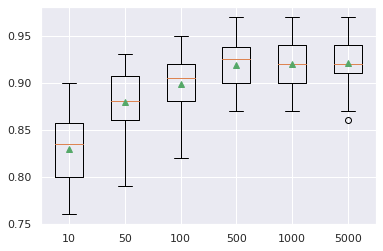

In [ ]:
# explore gradient boosting number of trees effect on performance
from numpy import mean
from numpy import std
from sklearn.datasets import make_classification
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.ensemble import GradientBoostingClassifier
from matplotlib import pyplot

# get the dataset
def get_dataset():
	X, y = make_classification(n_samples=1000, n_features=20, n_informative=15, n_redundant=5, random_state=7)
	return X, y

# get a list of models to evaluate
def get_models():
	models = dict()
	# define number of trees to consider
	n_trees = [10, 50, 100, 500, 1000, 5000]
	for n in n_trees:
		models[str(n)] = GradientBoostingClassifier(n_estimators=n)
	return models

# evaluate a given model using cross-validation
def evaluate_model(model, X, y):
	# define the evaluation procedure
	cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
	# evaluate the model and collect the results
	scores = cross_val_score(model, X, y, scoring='accuracy', cv=cv, n_jobs=-1)
	return scores

# define dataset
X, y = get_dataset()
# get the models to evaluate
models = get_models()
# evaluate the models and store results
results, names = list(), list()
for name, model in models.items():
	# evaluate the model
	scores = evaluate_model(model, X, y)
	# store the results
	results.append(scores)
	names.append(name)
	# summarize the performance along the way
	print('>%s %.3f (%.3f)' % (name, mean(scores), std(scores)))
# plot model performance for comparison
pyplot.boxplot(results, labels=names, showmeans=True)
pyplot.show()

### Explore Number of Samples

The number of samples used to fit each tree can be varied. This means that each tree is fit on a randomly selected subset of the training dataset.

Using fewer samples introduces more variance for each tree, although it can improve the overall performance of the model.

The number of samples used to fit each tree is specified by the “subsample” argument and can be set to a fraction of the training dataset size. By default, it is set to 1.0 to use the entire training dataset.

>0.1 0.864 (0.045)
>0.2 0.888 (0.031)
>0.3 0.899 (0.034)
>0.4 0.900 (0.034)
>0.5 0.909 (0.029)
>0.6 0.905 (0.025)
>0.7 0.905 (0.031)
>0.8 0.906 (0.037)
>0.9 0.899 (0.034)
>1.0 0.898 (0.030)


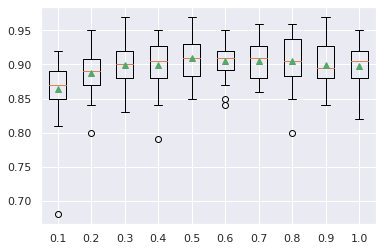

In [ ]:
# explore gradient boosting ensemble number of samples effect on performance
from numpy import mean
from numpy import std
from numpy import arange
from sklearn.datasets import make_classification
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.ensemble import GradientBoostingClassifier
from matplotlib import pyplot

# get the dataset
def get_dataset():
	X, y = make_classification(n_samples=1000, n_features=20, n_informative=15, n_redundant=5, random_state=7)
	return X, y

# get a list of models to evaluate
def get_models():
	models = dict()
	# explore sample ratio from 10% to 100% in 10% increments
	for i in arange(0.1, 1.1, 0.1):
		key = '%.1f' % i
		models[key] = GradientBoostingClassifier(subsample=i)
	return models

# evaluate a given model using cross-validation
def evaluate_model(model, X, y):
	# define the evaluation procedure
	cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
	# evaluate the model and collect the results
	scores = cross_val_score(model, X, y, scoring='accuracy', cv=cv, n_jobs=-1)
	return scores

# define dataset
X, y = get_dataset()
# get the models to evaluate
models = get_models()
# evaluate the models and store results
results, names = list(), list()
for name, model in models.items():
	# evaluate the model
	scores = evaluate_model(model, X, y)
	# store the results
	results.append(scores)
	names.append(name)
	# summarize the performance along the way
	print('>%s %.3f (%.3f)' % (name, mean(scores), std(scores)))
# plot model performance for comparison
pyplot.boxplot(results, labels=names, showmeans=True)
pyplot.show()

### Explore Number of Features

The number of features used to fit each decision tree can be varied.

Like changing the number of samples, changing the number of features introduces additional variance into the model, which may improve performance, although it might require an increase in the number of trees.

The number of features used by each tree is taken as a random sample and is specified by the “max_features” argument and defaults to all features in the training dataset.

>1 0.869 (0.027)
>2 0.886 (0.034)
>3 0.891 (0.026)
>4 0.891 (0.030)
>5 0.895 (0.037)
>6 0.899 (0.032)
>7 0.900 (0.031)
>8 0.899 (0.035)
>9 0.895 (0.033)
>10 0.894 (0.032)
>11 0.900 (0.027)
>12 0.901 (0.030)
>13 0.905 (0.030)
>14 0.901 (0.029)
>15 0.898 (0.032)
>16 0.899 (0.030)
>17 0.901 (0.031)
>18 0.901 (0.031)
>19 0.901 (0.035)
>20 0.900 (0.030)


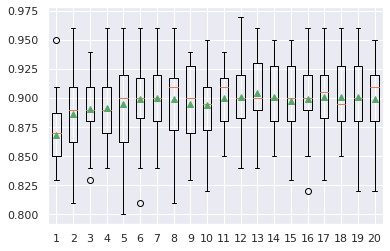

In [ ]:
# explore gradient boosting number of features on performance
from numpy import mean
from numpy import std
from sklearn.datasets import make_classification
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.ensemble import GradientBoostingClassifier
from matplotlib import pyplot

# get the dataset
def get_dataset():
	X, y = make_classification(n_samples=1000, n_features=20, n_informative=15, n_redundant=5, random_state=7)
	return X, y

# get a list of models to evaluate
def get_models():
	models = dict()
	# explore number of features from 1 to 20
	for i in range(1,21):
		models[str(i)] = GradientBoostingClassifier(max_features=i)
	return models

# evaluate a given model using cross-validation
def evaluate_model(model, X, y):
	# define the evaluation procedure
	cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
	# evaluate the model and collect the results
	scores = cross_val_score(model, X, y, scoring='accuracy', cv=cv, n_jobs=-1)
	return scores

# define dataset
X, y = get_dataset()
# get the models to evaluate
models = get_models()
# evaluate the models and store results
results, names = list(), list()
for name, model in models.items():
	# evaluate the model
	scores = evaluate_model(model, X, y)
	# store the results
	results.append(scores)
	names.append(name)
	# summarize the performance along the way
	print('>%s %.3f (%.3f)' % (name, mean(scores), std(scores)))
# plot model performance for comparison
pyplot.boxplot(results, labels=names, showmeans=True)
pyplot.show()

### Explore Learning Rate

Learning rate controls the amount of contribution that each model has on the ensemble prediction.

Smaller rates may require more decision trees in the ensemble, whereas larger rates may require an ensemble with fewer trees. It is common to explore learning rate values on a log scale, such as between a very small value like 0.0001 and 1.0.

The learning rate can be controlled via the “learning_rate” argument and defaults to 0.1.

>0.0001 0.761 (0.043)
>0.0010 0.781 (0.034)
>0.0100 0.836 (0.034)
>0.1000 0.899 (0.030)
>1.0000 0.909 (0.030)


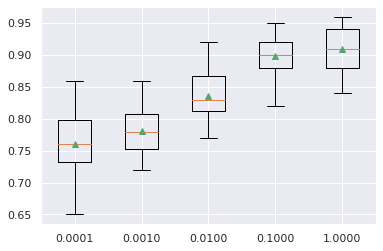

In [ ]:
# explore gradient boosting ensemble learning rate effect on performance
from numpy import mean
from numpy import std
from sklearn.datasets import make_classification
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.ensemble import GradientBoostingClassifier
from matplotlib import pyplot

# get the dataset
def get_dataset():
	X, y = make_classification(n_samples=1000, n_features=20, n_informative=15, n_redundant=5, random_state=7)
	return X, y

# get a list of models to evaluate
def get_models():
	models = dict()
	# define learning rates to explore
	for i in [0.0001, 0.001, 0.01, 0.1, 1.0]:
		key = '%.4f' % i
		models[key] = GradientBoostingClassifier(learning_rate=i)
	return models

# evaluate a given model using cross-validation
def evaluate_model(model, X, y):
	# define the evaluation procedure
	cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
	# evaluate the model and collect the results
	scores = cross_val_score(model, X, y, scoring='accuracy', cv=cv, n_jobs=-1)
	return scores

# define dataset
X, y = get_dataset()
# get the models to evaluate
models = get_models()
# evaluate the models and store results
results, names = list(), list()
for name, model in models.items():
	# evaluate the model
	scores = evaluate_model(model, X, y)
	# store the results
	results.append(scores)
	names.append(name)
	# summarize the performance along the way
	print('>%s %.3f (%.3f)' % (name, mean(scores), std(scores)))
# plot model performance for comparison
pyplot.boxplot(results, labels=names, showmeans=True)
pyplot.show()

### Explore Tree Depth

Like varying the number of samples and features used to fit each decision tree, varying the depth of each tree is another important hyperparameter for gradient boosting.

The tree depth controls how specialized each tree is to the training dataset: how general or overfit it might be. Trees are preferred that are not too shallow and general (like AdaBoost) and not too deep and specialized (like bootstrap aggregation).

Gradient boosting performs well with trees that have a modest depth finding a balance between skill and generality.

Tree depth is controlled via the “max_depth” argument and defaults to 3.

>1 0.834 (0.031)
>2 0.877 (0.029)
>3 0.899 (0.031)
>4 0.906 (0.031)
>5 0.914 (0.031)
>6 0.914 (0.034)
>7 0.905 (0.032)
>8 0.891 (0.032)
>9 0.844 (0.035)
>10 0.828 (0.036)


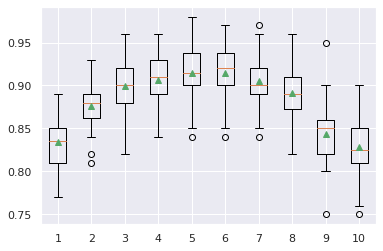

In [ ]:
# explore gradient boosting tree depth effect on performance
from numpy import mean
from numpy import std
from sklearn.datasets import make_classification
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.ensemble import GradientBoostingClassifier
from matplotlib import pyplot

# get the dataset
def get_dataset():
	X, y = make_classification(n_samples=1000, n_features=20, n_informative=15, n_redundant=5, random_state=7)
	return X, y

# get a list of models to evaluate
def get_models():
	models = dict()
	# define max tree depths to explore between 1 and 10
	for i in range(1,11):
		models[str(i)] = GradientBoostingClassifier(max_depth=i)
	return models

# evaluate a given model using cross-validation
def evaluate_model(model, X, y):
	# define the evaluation procedure
	cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
	# evaluate the model and collect the results
	scores = cross_val_score(model, X, y, scoring='accuracy', cv=cv, n_jobs=-1)
	return scores

# define dataset
X, y = get_dataset()
# get the models to evaluate
models = get_models()
# evaluate the models and store results
results, names = list(), list()
for name, model in models.items():
	# evaluate the model
	scores = evaluate_model(model, X, y)
	# store the results
	results.append(scores)
	names.append(name)
	# summarize the performance along the way
	print('>%s %.3f (%.3f)' % (name, mean(scores), std(scores)))
# plot model performance for comparison
pyplot.boxplot(results, labels=names, showmeans=True)
pyplot.show()

## Grid Search Hyperparameters



In [ ]:
# example of grid searching key hyperparameters for gradient boosting on a classification dataset
from sklearn.datasets import make_classification
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import GradientBoostingClassifier
# define dataset
X, y = make_classification(n_samples=1000, n_features=20, n_informative=15, n_redundant=5, random_state=7)
# define the model with default hyperparameters
model = GradientBoostingClassifier()
# define the grid of values to search
grid = dict()
grid['n_estimators'] = [10, 50, 100, 500]
grid['learning_rate'] = [0.0001, 0.001, 0.01, 0.1, 1.0]
grid['subsample'] = [0.5, 0.7, 1.0]
grid['max_depth'] = [3, 7, 9]
# define the evaluation procedure
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
# define the grid search procedure
grid_search = GridSearchCV(estimator=model, param_grid=grid, n_jobs=-1, cv=cv, scoring='accuracy')
# execute the grid search
grid_result = grid_search.fit(X, y)
# summarize the best score and configuration
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
# summarize all scores that were evaluated
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

evaluation
grid search
fit
Best: 0.943667 using {'learning_rate': 0.1, 'max_depth': 9, 'n_estimators': 500, 'subsample': 0.5}
0.530000 (0.090480) with: {'learning_rate': 0.0001, 'max_depth': 3, 'n_estimators': 10, 'subsample': 0.5}
0.525333 (0.076539) with: {'learning_rate': 0.0001, 'max_depth': 3, 'n_estimators': 10, 'subsample': 0.7}
0.524000 (0.072874) with: {'learning_rate': 0.0001, 'max_depth': 3, 'n_estimators': 10, 'subsample': 1.0}
0.775000 (0.036309) with: {'learning_rate': 0.0001, 'max_depth': 3, 'n_estimators': 50, 'subsample': 0.5}
0.766333 (0.038339) with: {'learning_rate': 0.0001, 'max_depth': 3, 'n_estimators': 50, 'subsample': 0.7}
0.738667 (0.049982) with: {'learning_rate': 0.0001, 'max_depth': 3, 'n_estimators': 50, 'subsample': 1.0}
0.825333 (0.033935) with: {'learning_rate': 0.0001, 'max_depth': 3, 'n_estimators': 100, 'subsample': 0.5}
0.809000 (0.037359) with: {'learning_rate': 0.0001, 'max_depth': 3, 'n_estimators': 100, 'subsample': 0.7}
0.761000 (0.043077) with

# Decision Trees

## General

In [ ]:
import pandas as pd
import numpy as np
from sklearn import datasets

FEATURE_NAMES = ['Sepal Length', 'Sepal Width', 'Petal Length', 'Petal Width']

iris = datasets.load_iris()
X = pd.DataFrame(iris.data, columns = FEATURE_NAMES)
y = iris.target

In [ ]:
from sklearn.tree import DecisionTreeClassifier
model = DecisionTreeClassifier()
model.fit(X,y)

DecisionTreeClassifier()

In [ ]:
from sklearn.tree import export_graphviz
export_graphviz(model, 'tree.dot', feature_names = FEATURE_NAMES)
# X.columns

In [ ]:
! dot -Tpng tree.dot -o tree.png


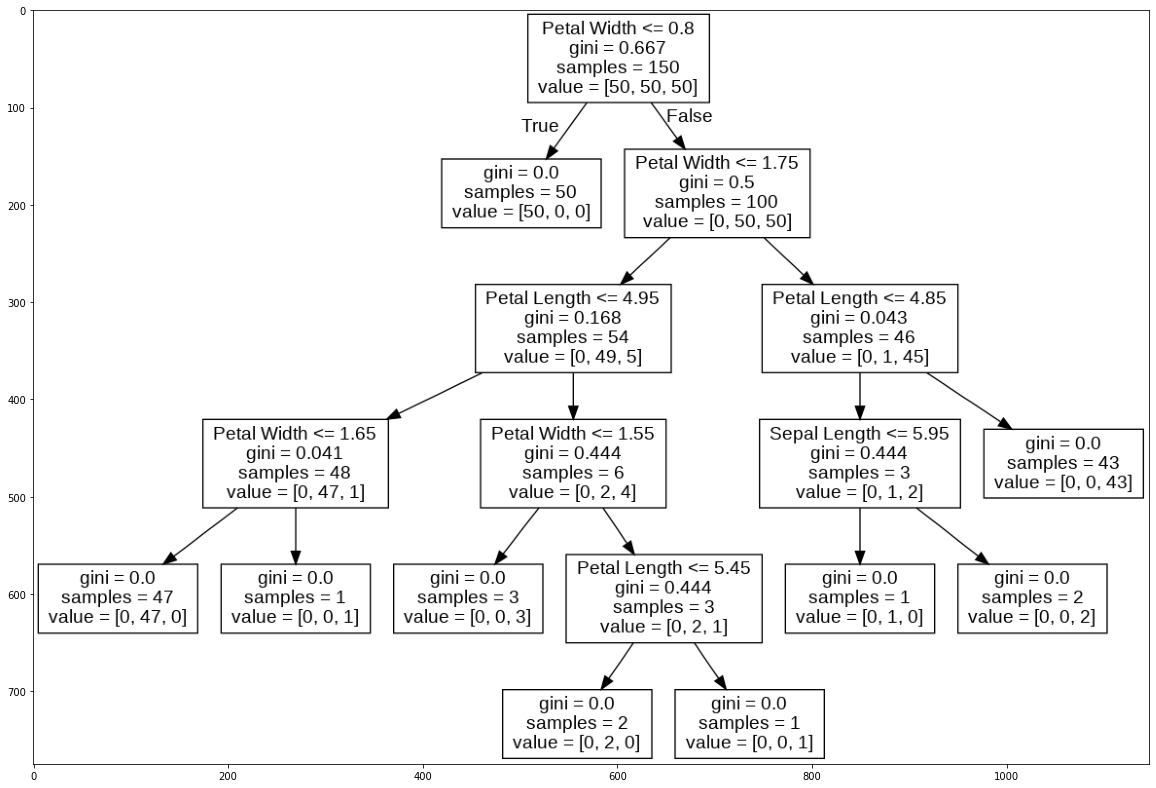

In [ ]:
import matplotlib.pyplot as plt
import cv2
%matplotlib inline
img = cv2.imread('tree.png')
plt.figure(figsize = (20, 20))
plt.imshow(img)

## Patient and Drugs

In [ ]:
import numpy as np
import pandas as pd
from sklearn.tree import DecisionTreeClassifier

magine that you are a medical researcher compiling data for a study. You have collected data about a set of patients, all of whom suffered from the same illness. During their course of treatment, each patient responded to one of 5 medications, Drug A, Drug B, Drug c, Drug x and y.


Part of your job is to build a model to find out which drug might be appropriate for a future patient with the same illness. The feature sets of this dataset are Age, Sex, Blood Pressure, and Cholesterol of patients, and the target is the drug that each patient responded to.


It is a sample of binary classifier, and you can use the training part of the dataset to build a decision tree, and then use it to predict the class of a unknown patient, or to prescribe it to a new patient.

### Downloading the data

In [ ]:
!wget -O drug200.csv https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/ML0101ENv3/labs/drug200.csv

--2022-12-20 12:46:25--  https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/ML0101ENv3/labs/drug200.csv
Resolving s3-api.us-geo.objectstorage.softlayer.net (s3-api.us-geo.objectstorage.softlayer.net)... 67.228.254.196
Connecting to s3-api.us-geo.objectstorage.softlayer.net (s3-api.us-geo.objectstorage.softlayer.net)|67.228.254.196|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 6027 (5.9K) [text/csv]
Saving to: ‘drug200.csv’

drug200.csv         100%[===================>]   5.89K  --.-KB/s    in 0s      

2022-12-20 12:46:26 (1.41 GB/s) - ‘drug200.csv’ saved [6027/6027]



In [ ]:
my_data = pd.read_csv("drug200.csv", delimiter=",")
my_data[0:10]

,Age,Sex,BP,Cholesterol,Na_to_K,Drug
0,23,F,HIGH,HIGH,25.355,drugY
1,47,M,LOW,HIGH,13.093,drugC
2,47,M,LOW,HIGH,10.114,drugC
3,28,F,NORMAL,HIGH,7.798,drugX
4,61,F,LOW,HIGH,18.043,drugY
5,22,F,NORMAL,HIGH,8.607,drugX
6,49,F,NORMAL,HIGH,16.275,drugY
7,41,M,LOW,HIGH,11.037,drugC
8,60,M,NORMAL,HIGH,15.171,drugY
9,43,M,LOW,NORMAL,19.368,drugY


### Pre-processing


Using my_data as the Drug.csv data read by pandas, declare the following variables:


1.   X as the Feature Matrix (data of my_data)

2.   y as the response vector (target)

Remove the column containing the target name since it doesn't contain numeric values.

In [ ]:
X = my_data[['Age', 'Sex', 'BP', 'Cholesterol', 'Na_to_K']].values
X[0:5]

array([[23, 'F', 'HIGH', 'HIGH', 25.355],
       [47, 'M', 'LOW', 'HIGH', 13.093],
       [47, 'M', 'LOW', 'HIGH', 10.114],
       [28, 'F', 'NORMAL', 'HIGH', 7.798],
       [61, 'F', 'LOW', 'HIGH', 18.043]], dtype=object)

As you may figure out, some features in this dataset are categorical such as Sex or BP. Unfortunately, Sklearn Decision Trees do not handle categorical variables. But still we can convert these features to numerical values. pandas.get_dummies() Convert categorical variable into dummy/indicator variables.



In [ ]:
from sklearn import preprocessing
le_sex = preprocessing.LabelEncoder()
le_sex.fit(['F','M'])
X[:,1] = le_sex.transform(X[:,1]) 


le_BP = preprocessing.LabelEncoder()
le_BP.fit([ 'LOW', 'NORMAL', 'HIGH'])
X[:,2] = le_BP.transform(X[:,2])


le_Chol = preprocessing.LabelEncoder()
le_Chol.fit([ 'NORMAL', 'HIGH'])
X[:,3] = le_Chol.transform(X[:,3]) 

X[0:5]

array([[23, 0, 0, 0, 25.355],
       [47, 1, 1, 0, 13.093],
       [47, 1, 1, 0, 10.114],
       [28, 0, 2, 0, 7.798],
       [61, 0, 1, 0, 18.043]], dtype=object)

In [ ]:
y = my_data["Drug"]
y[0:5]

0    drugY
1    drugC
2    drugC
3    drugX
4    drugY
Name: Drug, dtype: object

### Setting up the Decision Tree

We will be using train/test split on our decision tree. Let's import train_test_split from sklearn.cross_validation.



In [ ]:
from sklearn.model_selection import train_test_split


In [ ]:
X_trainset, X_testset, y_trainset, y_testset = train_test_split(X, y, test_size=0.3, random_state=42)


### Modeling

We will first create an instance of the DecisionTreeClassifier called drugTree.
Inside of the classifier, specify criterion="entropy" so we can see the information gain of each node.

In [ ]:
drugTree = DecisionTreeClassifier(criterion="entropy", max_depth = 4)
drugTree # it shows the default parameters

DecisionTreeClassifier(criterion='entropy', max_depth=4)

In [ ]:
drugTree.fit(X_trainset,y_trainset)


DecisionTreeClassifier(criterion='entropy', max_depth=4)

### Prediction

Let's make some predictions on the testing dataset and store it into a variable called predTree.



In [ ]:
predTree = drugTree.predict(X_testset)


In [ ]:
print (predTree [0:5])
print (y_testset [0:5])

['drugX' 'drugY' 'drugX' 'drugC' 'drugY']
95     drugX
15     drugY
30     drugX
158    drugC
128    drugY
Name: Drug, dtype: object


### Evaluation

In [ ]:
from sklearn import metrics
import matplotlib.pyplot as plt
print("DecisionTrees's Accuracy: ", metrics.accuracy_score(y_testset, predTree))

DecisionTrees's Accuracy:  1.0


Accuracy classification score computes subset accuracy: the set of labels predicted for a sample must exactly match the corresponding set of labels in y_true.


In multilabel classification, the function returns the subset accuracy. If the entire set of predicted labels for a sample strictly match with the true set of labels, then the subset accuracy is 1.0; otherwise it is 0.0.

### Visualization



In [ ]:
!pip install pydotplus
!pip install graphviz

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from six import StringIO
import pydotplus
import matplotlib.image as mpimg
from sklearn import tree
%matplotlib inline 

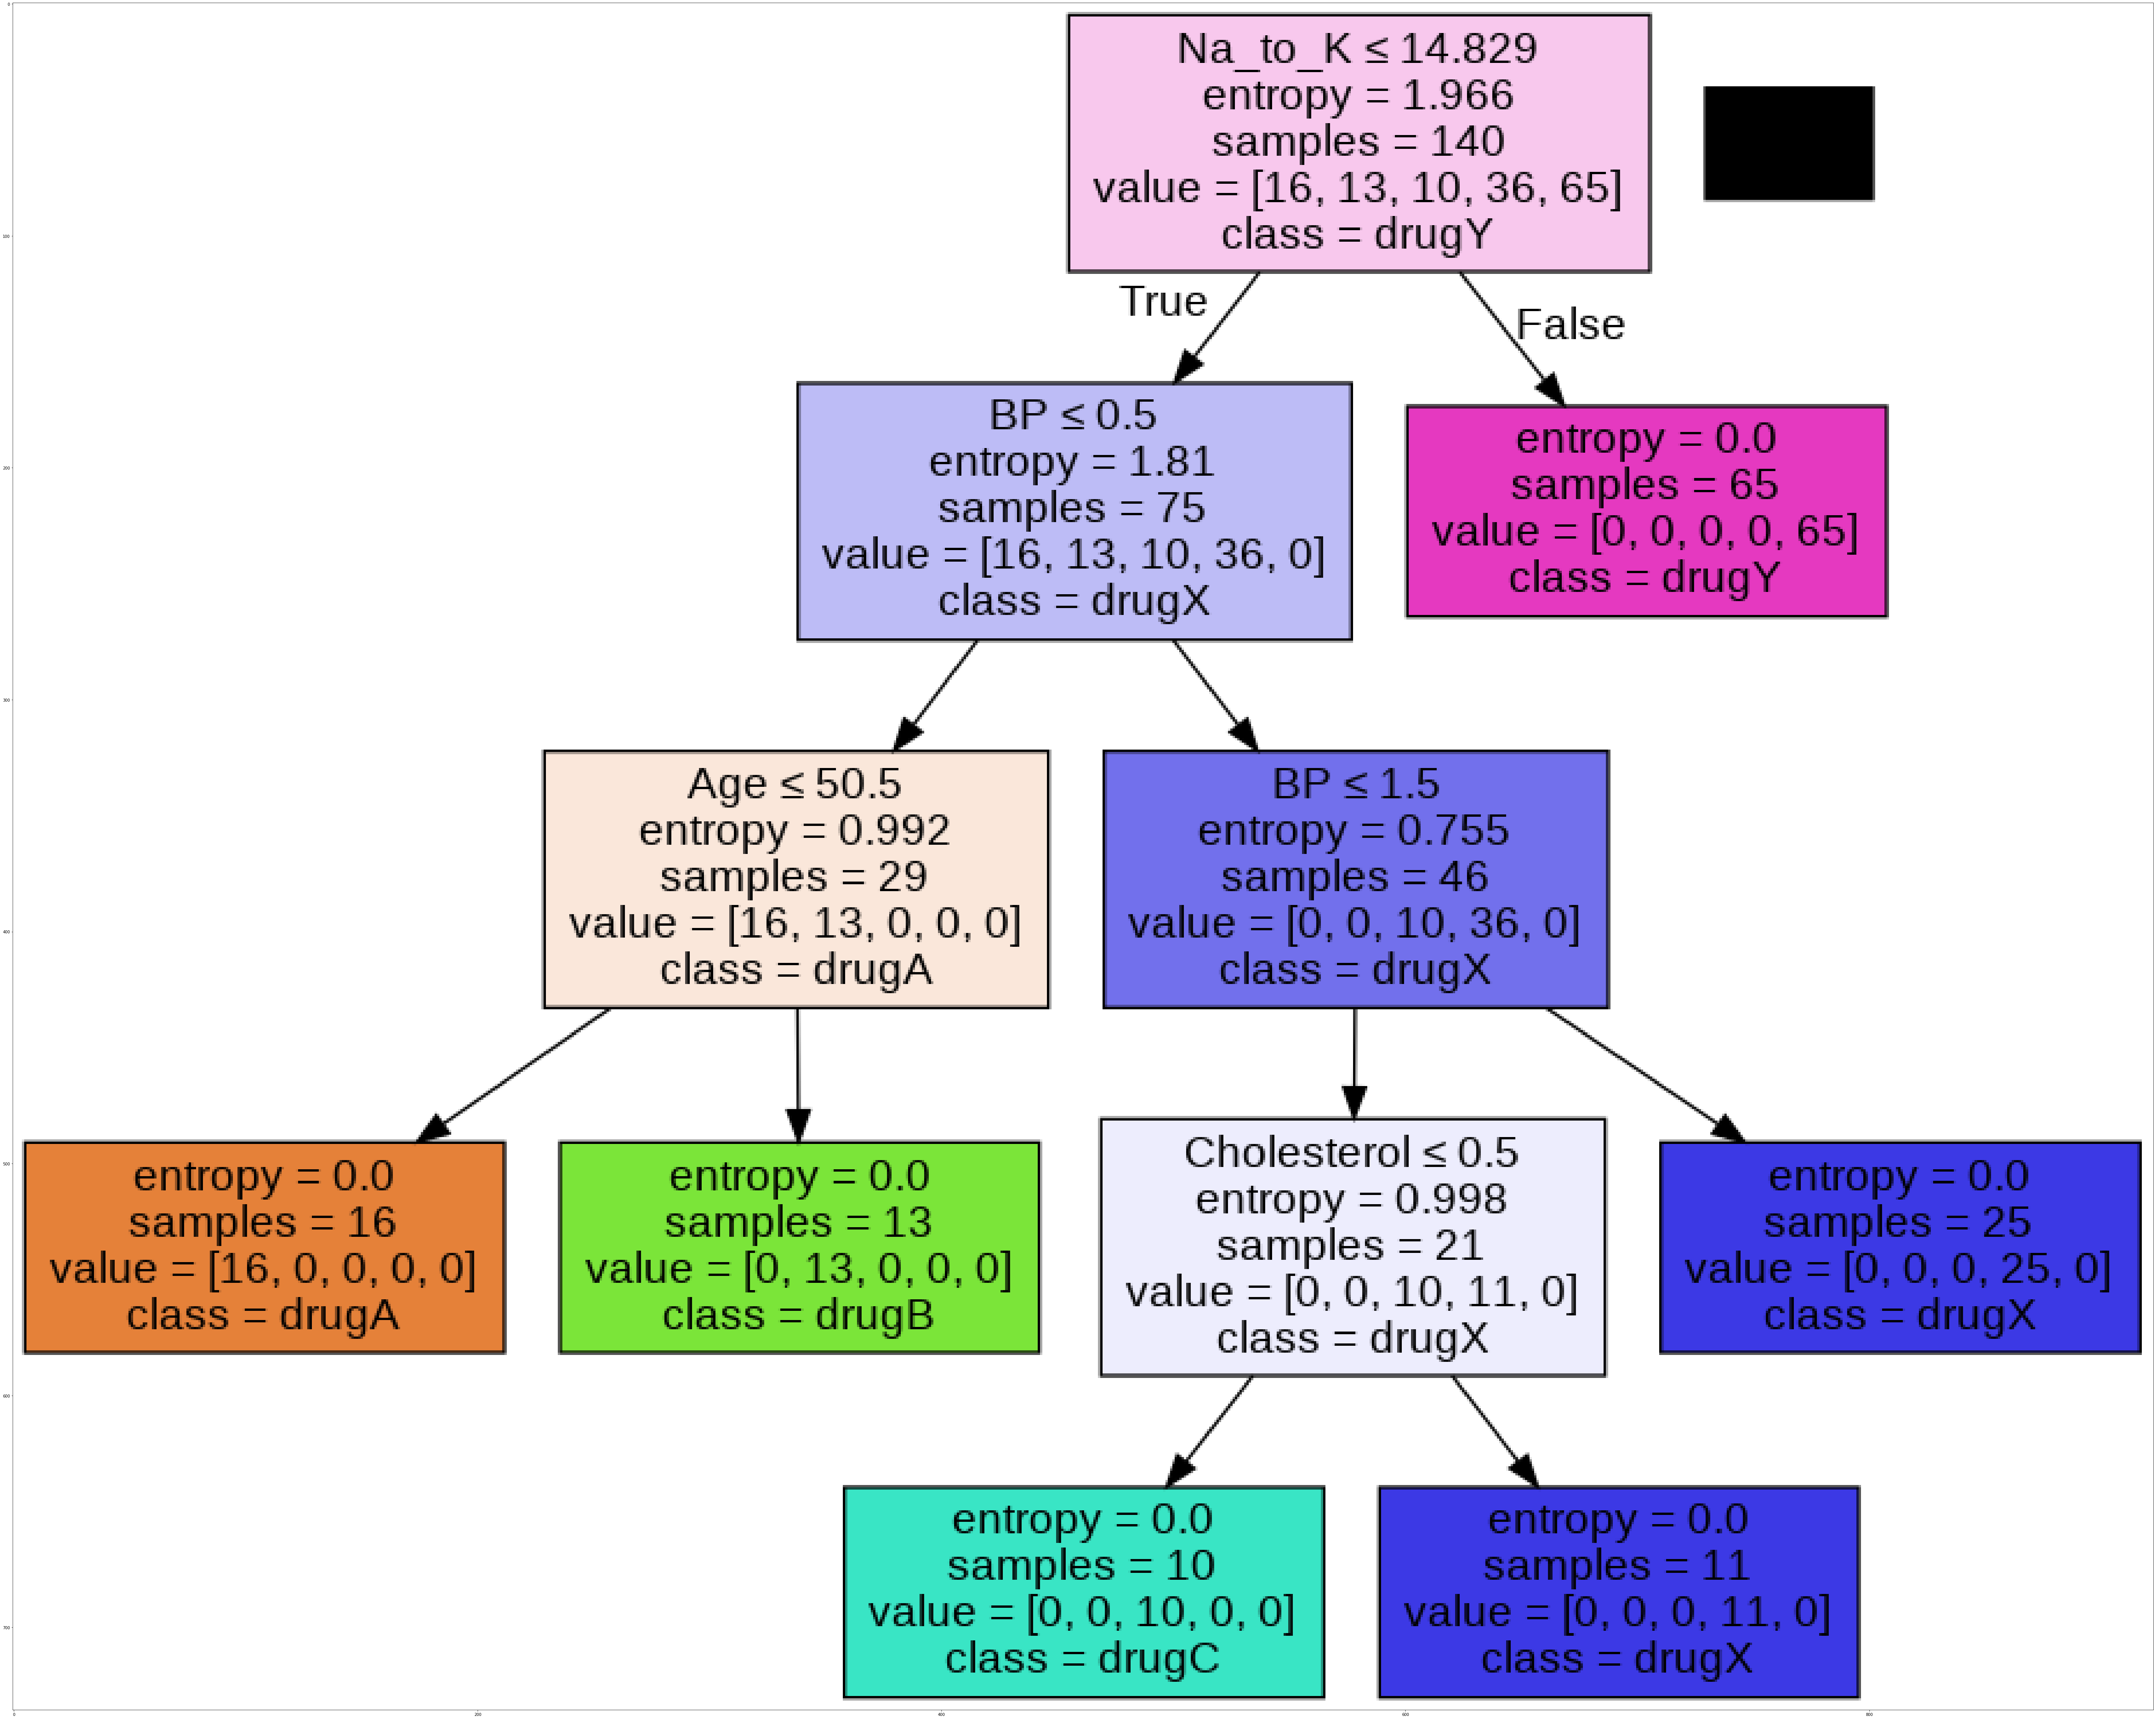

In [ ]:
dot_data = StringIO()
filename = "drugtree.png"
featureNames = my_data.columns[0:5]
targetNames = my_data["Drug"].unique().tolist()
out=tree.export_graphviz(drugTree,feature_names=featureNames, out_file=dot_data, class_names= np.unique(y_trainset), filled=True,  special_characters=True,rotate=False)  
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
graph.write_png(filename)
img = mpimg.imread(filename)
plt.figure(figsize=(100, 200))
plt.imshow(img,interpolation='nearest')

#### https://github.com/ageron/handson-ml2/blob/master/06_decision_trees.ipynb